In [1]:
import random
import re
import numpy as np
import psycopg2 as db
import pandas as pd
import geopandas as gpd
from shapely.wkb import loads
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString

# Compare pgRouting Speedup Execution Times

In our tutorial on how to speed up pgRouting queries, we have presented a couple of ways to make dijkstra's algorithm in pgRouting run faster even on large road data sets. In this notebook, we're taking it a little further and instead of just running the queries on one route, we're comparing them across various routes of different lengths.

In [2]:
db_creds = {"dbname": "gis", "user": "<user>", "password": "<pass>", "host": "localhost", "port": "5450"}
conn = db.connect(**db_creds)
cur = conn.cursor()

In [3]:
norcal_boundary = gpd.read_file("./data/norcal.geojson")

In [4]:
minx, miny, maxx, maxy = norcal_boundary.geometry.total_bounds
poly_norcal = norcal_boundary.iloc[0].geometry

def random_coordinates(n, min_dist, max_dist):
    assert min_dist < max_dist # make sure parameters are valid
    
    coordinates = []
    for _ in range(n):
        counter = 0
        in_poly = False
        while not in_poly:
            counter += 1
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            p = Point(x, y)
            if poly_norcal.contains(p):
                # Make sure all route segments are within limits
                if coordinates:
                    if not min_dist < p.distance(Point(coordinates[-1])) < max_dist:
                        continue
                coordinates.append([x, y])
                in_poly = True
            if counter > 1000:
                raise ValueError("Distance settings are too restrictive. Try a wider range and remember it's in degrees.")

    return coordinates



In [5]:
coords = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in random_coordinates(50000, 0.0001, 1)], crs=4326)

In [6]:
geoms = []
data = []
for rix, row in coords.iterrows():
    from_geom = row.geometry
    to_geom = coords.sample(1).iloc[0].geometry
    euclidean = from_geom.distance(to_geom)
    if euclidean == 0:
        continue
    geoms.append(LineString([from_geom, to_geom]))
    data.append({"euclidean": euclidean})
from_to = gpd.GeoDataFrame(geometry=geoms, data=data, crs=4326)

In [7]:
from_to["eucl_rounded"] = np.floor(from_to.euclidean)
from_to = from_to.query("euclidean < 10")
#from_to["eucl_rounded"] = from_to["eucl_rounded"].apply(lambda x: x if x < 8 else 7)  # group smaller groups together

In [8]:
min_ = min(from_to.groupby("eucl_rounded").size()) # let's get somewhat of a uniform distribution along the eucl. distance
samples = []
for name, group in from_to.groupby("eucl_rounded"):
    samples.append(group.sample(min_))

df = pd.concat(samples)
df = df.reset_index(drop=True)

In [9]:
df

,euclidean,geometry,eucl_rounded
0,0.356254,"LINESTRING (-121.40539 37.95346, -121.04936 37...",0.0
1,0.248467,"LINESTRING (-121.71581 41.02799, -121.87122 41...",0.0
2,0.809657,"LINESTRING (-121.38350 38.13838, -120.83899 38...",0.0
3,0.956485,"LINESTRING (-118.17503 36.74170, -117.23032 36...",0.0
4,0.563828,"LINESTRING (-121.11685 39.71269, -120.64310 40...",0.0
...,...,...,...
125,9.425956,"LINESTRING (-116.24535 35.87302, -123.76732 41...",9.0
126,9.637356,"LINESTRING (-124.05723 41.84372, -116.40563 35...",9.0
127,9.014089,"LINESTRING (-123.48270 40.82558, -115.88108 35...",9.0
128,9.019367,"LINESTRING (-116.37523 36.22514, -123.53619 41...",9.0


In [11]:
queries = {
        "baseline": """EXPLAIN (ANALYZE, COSTS OFF, TIMING OFF)
                        WITH start AS (
                          SELECT topo.source --could also be topo.target
                          FROM norcal_2po_4pgr as topo
                          ORDER BY topo.geom_way <-> ST_SetSRID(
                            st_makepoint(%s,%s),
                          4326)
                          LIMIT 1
                        ),
                        destination AS (
                          SELECT topo.source --could also be topo.target
                          FROM norcal_2po_4pgr as topo
                          ORDER BY topo.geom_way <-> ST_SetSRID(
                            st_makepoint(%s,%s),
                          4326)
                          LIMIT 1
                        )
                        SELECT ST_Union(geom_way) as geom
                        FROM pgr_dijkstra('
                            SELECT id,
                                 source,
                                 target,
                                 ST_Length(ST_Transform(geom_way, 3857)) AS cost,
                                 ST_Length(ST_Transform(geom_way, 3857)) AS reverse_cost
                                FROM norcal_2po_4pgr',
                            array(SELECT source FROM start),
                            array(SELECT source FROM destination),
                            directed := true) AS di
                        JOIN   norcal_2po_4pgr AS pt
                          ON   di.edge = pt.id;""",
    "fixed_cost": """EXPLAIN (ANALYZE, COSTS OFF, TIMING OFF)
                    WITH start AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    ),
                    destination AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    )
                    SELECT ST_Union(geom_way) as geom
                    FROM pgr_dijkstra('
                        SELECT id,
                             source,
                             target,
                            cost,
                            reverse_cost
                            FROM norcal_2po_4pgr',
                        array(SELECT source FROM start),
                        array(SELECT source FROM destination),
                        directed := true) AS di
                    JOIN   norcal_2po_4pgr AS pt
                      ON   di.edge = pt.id;""",
    "bbox": """EXPLAIN (ANALYZE, COSTS OFF, TIMING OFF)
                    WITH start AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    ),
                    destination AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    )
                SELECT ST_Union(geom_way) as geom
                FROM pgr_dijkstra('
                    SELECT id,
                         source,
                         target,
                        cost,
                        reverse_cost
                        FROM norcal_2po_4pgr as e,
                    (SELECT ST_Expand(ST_Extent(geom_way),0.1) as box FROM norcal_2po_4pgr as b
                        WHERE b.source = '|| (SELECT source FROM start) ||'
                        OR b.source = ' || (SELECT source FROM destination) || ') as box WHERE e.geom_way && box.box'
                    ,
                    array(SELECT source FROM start),
                    array(SELECT source FROM destination),
                    directed := true) AS di
                JOIN   norcal_2po_4pgr AS pt
                  ON   di.edge = pt.id;""",
    "spatial_index": """EXPLAIN (ANALYZE, COSTS OFF, TIMING OFF)
                    WITH start AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr_gist as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    ),
                    destination AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr_gist as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    )
                SELECT ST_Union(geom_way) as geom
                FROM pgr_dijkstra('
                    SELECT id,
                         source,
                         target,
                        cost,
                        reverse_cost
                        FROM norcal_2po_4pgr_gist as e,
                    (SELECT ST_Expand(ST_Extent(geom_way),0.1) as box FROM norcal_2po_4pgr_gist as b
                        WHERE b.source = '|| (SELECT source FROM start) ||'
                        OR b.source = ' || (SELECT source FROM destination) || ') as box WHERE e.geom_way && box.box'
                    ,
                    array(SELECT source FROM start),
                    array(SELECT source FROM destination),
                    directed := true) AS di
                JOIN   norcal_2po_4pgr_gist AS pt
                  ON   di.edge = pt.id;""",
    "clustering": """EXPLAIN (ANALYZE, COSTS OFF, TIMING OFF)
                    WITH start AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr_clustered as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    ),
                    destination AS (
                      SELECT topo.source --could also be topo.target
                      FROM norcal_2po_4pgr_clustered as topo
                      ORDER BY topo.geom_way <-> ST_SetSRID(
                        st_makepoint(%s,%s),
                      4326)
                      LIMIT 1
                    )
                SELECT ST_Union(geom_way) as geom
                FROM pgr_dijkstra('
                    SELECT id,
                         source,
                         target,
                        cost,
                        reverse_cost
                        FROM norcal_2po_4pgr_clustered as e,
                    (SELECT ST_Expand(ST_Extent(geom_way),0.1) as box FROM norcal_2po_4pgr_clustered as b
                        WHERE b.source = '|| (SELECT source FROM start) ||'
                        OR b.source = ' || (SELECT source FROM destination) || ') as box WHERE e.geom_way && box.box'
                    ,
                    array(SELECT source FROM start),
                    array(SELECT source FROM destination),
                    directed := true) AS di
                JOIN   norcal_2po_4pgr_clustered AS pt
                  ON   di.edge = pt.id;"""
}

In [12]:
for key in queries:
    query = queries[key]
    for rix, row in df.reset_index(drop=True).iterrows():
        from_x, from_y, to_x, to_y = [
                                        row.geometry.coords[0][0],
                                        row.geometry.coords[0][1],
                                        row.geometry.coords[1][0],
                                        row.geometry.coords[1][1],
                                     ]
        cur.execute(query, [from_x, from_y, to_x, to_y])
        rows = cur.fetchall()
        exec_time = float(re.search("Execution Time: (.*) ms", rows[-1][0]).group(1))
        df.loc[rix, f"{key}_exec_time"] = exec_time
conn.commit()

In [13]:
df["eu_km"] = df.to_crs(3857).geometry.length / 1000
df = df.sort_values("eu_km")

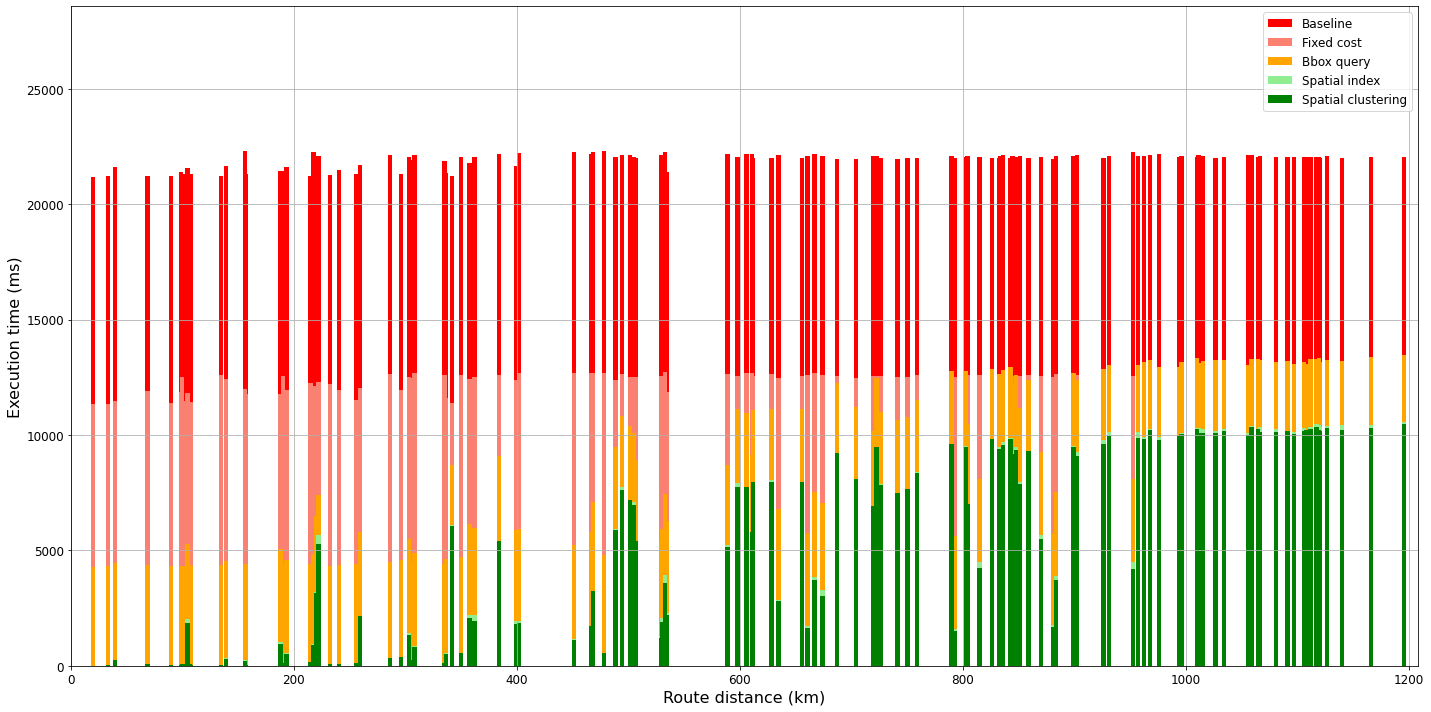

In [14]:
width = 4
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.grid(True)
ax.bar(data=df, height="baseline_exec_time", x="eu_km", width=width, color="red")
ax.bar(data=df, height="fixed_cost_exec_time", x="eu_km", width=width, color="salmon")
ax.bar(data=df, height="bbox_exec_time", x="eu_km", width=width, color="orange")
ax.bar(data=df, height="spatial_index_exec_time", x="eu_km", width=width, color="lightgreen")
ax.bar(data=df, height="clustering_exec_time", x="eu_km", width=width, color="green")
ax.legend(["Baseline", "Fixed cost", "Bbox query", "Spatial index", "Spatial clustering"], fontsize=12)
ax.set_xlim(0, max(df["eu_km"])*1.01)
ax.set_ylim(0, max(df["baseline_exec_time"]*1.28))
ax.set_xlabel("Route distance (km)", fontdict={"fontsize": 16})
ax.set_ylabel("Execution time (ms)", fontdict={"fontsize": 16})
ax.tick_params(labelsize = 12)
plt.tight_layout()
plt.savefig("./static/img/pgr_exec_times.jpg", dpi=200)